# Duboko učenje

### 2. laboratorijska vježba - Konvolucijski modeli

*Zagreb, 20.04.2020.*

## Izjava

Tekstovi zadataka se koriste samo u edukativne svrhe, te njihova prava još uvijek pripadaju autorima. Tekstovi zadatka preuzeti su sa [sljedeće poveznice](https://dlunizg.github.io/lab2/). Također, bilo kakve izmjene su isključivo radi estetike, i ne mijenjaju intelektualnog vlasnika na mene ili bilo kog tko uređuje ovu datoteku.

## Sadržaj

- [Zadatak 1](#Zadatak-1-%C2%A0%C2%A0%C2%A0-(25%))
- [Zadatak 2](#Zadatak-2-%C2%A0%C2%A0%C2%A0-(25%))
- [Zadatak 3](#Zadatak-3-%C2%A0%C2%A0%C2%A0-(25%))
- [Zadatak 4](#Zadatak-4-%C2%A0%C2%A0%C2%A0-(25%))

# Učitavanje resursa

In [1]:
import json
import os

from matplotlib import pyplot as plt
import torch

from IPython.core.display import display, HTML, Markdown, SVG

from task_3 import prepare_MNIST, CNNT3
from task_4 import prepare_CIFAR, CNNT4, analyze_evaluation, cifar_labels
from task_4 import SAVE_DIR as t4_save_dir

# Zadatak 1 &nbsp;&nbsp;&nbsp; (25%)

### Uvod u konvolucijske mreže

#### [Zadatak 2 ->](#Zadatak-2-%C2%A0%C2%A0%C2%A0-(25%))

## Postavke zadatka

In [2]:
t1_do_train = False  # True ako želite pokrenuti trening u podzadatku 8, False inače.

### Podzadatak 1

Dovršite implementacije potpuno povezanog sloja, sloja nelinearnosti te funkcije gubitka u razredima `FC`, `ReLU` i `SoftmaxCrossEntropyWithLogits`.

**Odgovor**:

Implementacije su ponuđene u `layers.py`

### Podzadatak 2

Kako biste bili sigurni da ste ispravno napisali sve slojeve testirajte gradijente pozivom skripte `check_grads.py`. Zadovoljavajuća relativna greška bi trebala biti manja od $10^{-5}$ ako vaši tenzori imaju dvostruku preciznost.

**Odgovor**:

Prvo treba izgraditi modul:

In [3]:
!python3 setup_cython.py build_ext --inplace

running build_ext


Zatim treba pokrenuti program:

In [4]:
!python3 check_grads.py

Convolution
Check grad wrt input
Relative error =  1.387713497584426e-09
Error norm =  2.708619411758534e-10
Check grad wrt params
Check weights:
Relative error =  3.960080099515749e-11
Error norm =  2.606048252692708e-10
Check biases:
Relative error =  2.2273920054210374e-12
Error norm =  2.6553929139417377e-11

MaxPooling
Check grad wrt input
Relative error =  3.2756455233944856e-12
Error norm =  9.520047457286901e-11

ReLU
Check grad wrt input
Relative error =  3.275620779981156e-12
Error norm =  5.448211281921029e-11

FC
Check grad wrt input
Relative error =  1.5526408894548135e-09
Error norm =  7.755267280874444e-10
Check grad wrt params
Check weights:
Relative error =  7.022404000356437e-10
Error norm =  7.706474875193658e-10
Check biases:
Relative error =  8.472355095041804e-10
Error norm =  1.4085252676109427e-10

SoftmaxCrossEntropyWithLogits
Relative error =  1.4583572252144326e-06
Error norm =  4.934061917260249e-10

L2Regularizer
Check grad wrt params
Relative error =  7.28

**Komentar**:

Ponekad greška `L2Regularizer` može premašiti $10^{-5}$. Valja napomenuti da se uvijek koristi jednostruka (`float32`) preciznost, pa je to za očekivati.

### Podzadatak 3

Sada prevedite Cython modul `im2col_cython.pyx` pozivom `python3 setup_cython.py build_ext --inplace` te po potrebi izmijenite varijable `DATA_DIR` i `SAVE_DIR`.

**Odgovor**: Ovo smo već napravili u prethodnom koraku.

### Podzadatak 4

Proučite i skicirajte model zadan objektom `net` u skripti `train.py`.

**Odgovor**:

Navedena mreža ilustrirana je sljedećom shemom:

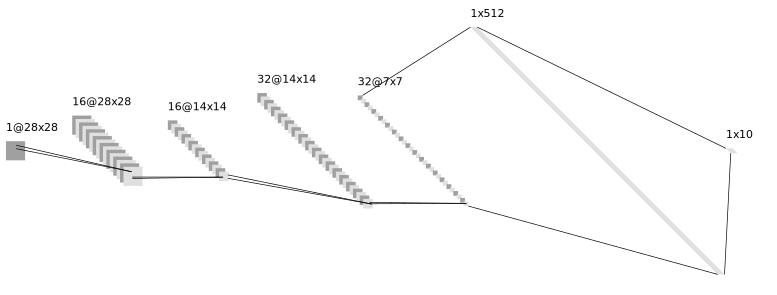

In [5]:
SVG(filename="res/task1_schematic.svg")

Ova shema je izrađena uz pomoć alata [NN SVG](https://alexlenail.me/NN-SVG/).

### Podzadatak 5

Odredite veličine tenzora te broj parametara u svakom sloju.

**Odgovor**:

- Prvi konvulucijski sloj
  - ulaz: $N \times 1 \times 28 \times 28$
  - $16$ filtera, $1$ kanal, dimenzija $5 \times 5$ uz pomak od $16$ elemenata: $416$ parametara.
  - izlaz: $N \times 16 \times 28 \times 28$
- Prvi udruživački sloj po maksimumu
  - ulaz: $N \times 16 \times 28 \times 28$
  - nema parametara
  - izlaz: $N \times 16 \times 14 \times 14$
- Drugi konvolucijski sloj
  - ulaz: $N \times 16 \times 14 \times 14$
  - $32$ filtera, $16$ kanala, dimenzija $5 \times 5$ uz pomak od $32$ elementa tj. $12832$ parametara
  - izlaz: $N \times 32 \times 14 \times 14$
- Drugi udruživački sloj po maksimumu
  - ulaz: $N \times 32 \times 14 \times 14$
  - nema parametara
  - izlaz: $N \times 32 \times 7 \times 7$

- Sloj spljošćivanja
  - ulaz: $N \times 32 \times 7 \times 7$
  - nema parametara
  - izlaz: $N \times 1568$

- Prvi potpuno povezani sloj
  - ulaz: $N \times 1568$
  - matrica $512 \times 1568$ i pomak od $512$ elemenata, tj. $803328$ parametara
  - izlaz: $N \times 512$
- Drugi potpuno povezani sloj
  - ulaz: $N \times 512$
  - matrica $10 \times 512$ i pomak od $10$ elemenata, tj. $5130$ parametara
  - izlaz: $N \times 10$

### Podzadatak 6

Odredite veličinu receptivnog polja značajki iz posljednjeg (drugog) konvolucijskog sloja.

**Odgovor**:

Po algoritmu pronađenom [ovdje](https://shawnleezx.github.io/blog/2017/02/11/calculating-receptive-field-of-cnn/):

- $l = 1, f = 1$: input
- $l = 5, f = 1$: conv_1
- $l = 6, f = 2$: maxpool_1
- $l = 14, f = 2$: conv_2

Dakle, receptivno polje posljednjeg konvolucijskog sloja je $14$.

### Podzadatak 7

Procijenite ukupnu količinu memorije za pohranjivanje aktivacija koje su potrebne za provođenje backpropa ako učimo s mini-grupama od $50$ slika.

**Odgovor**:

Treba pohraniti $50$ gradijenata za sve naučive parametre. Pobrojimo ih po slojevima:

- Prvi konvolucijski: $416$ parametara
- Drugi konvolucijski: $12832$ parametara
- Prvi potpuno povezani: $803328$ parametara
- Drugi potpuno povezani: $5130$ parametara

Ubacimo sad ovo u izračun:

In [6]:
t1_s7_conv_1_size = 416
t1_s7_conv_2_size = 12832
t1_s7_fc_1_size = 803328
t1_s7_fc_2_size = 5130

t1_s7_total_size = t1_s7_conv_1_size + t1_s7_conv_2_size + \
                   t1_s7_fc_1_size + t1_s7_fc_2_size

t1_s7_total_size_50_batches = 50 * t1_s7_total_size

t1_s7_total_size_bytes = t1_s7_total_size_50_batches * 4

In [7]:
Markdown(f"<br>Ukupno nam treba **{t1_s7_total_size_bytes} B**, "
         f"tj. **{t1_s7_total_size_bytes / 1e6:.02f} MB** memorije.")

<br>Ukupno nam treba **164341200 B**, tj. **164.34 MB** memorije.

**Komentar**: Naravno, s ovo je samo procjena donje granice. Tijekom izvršavanja je potrebna dodatna memorija jer nije kao da se samo pamte gradijenti koji se mijenjaju. Međutim, kako je alokacija i dealokacija ove memorije ovisna o implementaciji knjižnice i programskog jezika, pružamo procjenu samo za naučive gradijente, jer ćemo njih uvijek morati pamtiti. Isto tako, pretpostavilo se da nema kompresije podataka. Uz kompresiju (npr. rijetke matrice) bi ovi brojevi mogli biti manji.

### Podzadatak 8

Napokon, pokrenite učenje modela pozivom skripte `train.py`.

In [8]:
t1_s8_display = ""

if t1_do_train:
    !python3 train.py
else:
    t1_s8_display = "<br>Postavljeno je da se treniranje **ne pokreće** " +\
                    "(`t1_do_train == False`)."
    
Markdown(t1_s8_display)

<br>Postavljeno je da se treniranje **ne pokreće** (`t1_do_train == False`).

### Podzadatak 9

Odredite vezu između početnog iznosa funkcije gubitka i broja razreda $C$.

**Odgovor**:

Što je veći broj $C$, to nasumično inicijalizirana mreža, za koju pretpostavljamo da predviđa rezultate kao da izvlači klasifikacije iz uniformne razdiobe, ima više šanse pogriješiti. Stoga, porastom broja $C$ će početni iznos funkcije gubitka rasti.

# Zadatak 2 &nbsp;&nbsp;&nbsp; (25%)

### L2 regularizacija

#### [<- Zadatak 1](#Zadatak-1-%C2%A0%C2%A0%C2%A0-(25%)) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Zadatak 3 ->](#Zadatak-3-%C2%A0%C2%A0%C2%A0-(25%))

## Postavke zadatka

In [9]:
t2_do_train = False  # True ako želite pokrenuti trening u podzadatku 1, False inače.
                     # Upozorenje - to traje skoro 1 sat!

t2_root_path = "out_l2reg"
t2_results_path = os.path.join(t2_root_path, "results.json")
t2_weight_decays = [1e-3, 1e-2, 1e-1]

U ovom zadatku trebate dodati podršku za L2 regularizaciju parametara.

### Podzadatak 1

Dovršite implementaciju sloja `L2Regularizer` te naučite regularizirani model iz prethodnog zadatka koji se nalazi u `train_l2reg.py`.

**Odgovor**:

Implementacija `L2Regularizer` nalazi se u `layers.py`.

In [10]:
t2_s1_display = ""

if t2_do_train:
    !python3 train_l2reg.py
else:
    t2_s1_display = "<br>Postavljeno je da se treniranje **ne pokreće** " +\
                    "(`t2_do_train == False`)."
    
Markdown(t2_s1_display)

<br>Postavljeno je da se treniranje **ne pokreće** (`t2_do_train == False`).

### Podzadatak 2

Proučite efekte regularizacijskog hiper-parametra tako da naučite tri različita modela s $\lambda = 10^{-3}$, $\lambda = 10^{-2}$, $\lambda = 10^{-1}$ te usporedite naučene filtre u prvom sloju i dobivenu točnost.

**Odgovor**:

Spremili smo sliku u datoteke naziva `out_l2reg/lambda0.001`, `out_l2reg/lambda0.010` i `out_l2reg/lambda0.100`. Ako učitamo posljednje datoteke, možemo prikazati sljedeće slike:

In [11]:
t2_s2_folder_paths = [os.path.join(t2_root_path, x) for x in sorted(os.listdir(t2_root_path))]
t2_s2_image_paths = list()

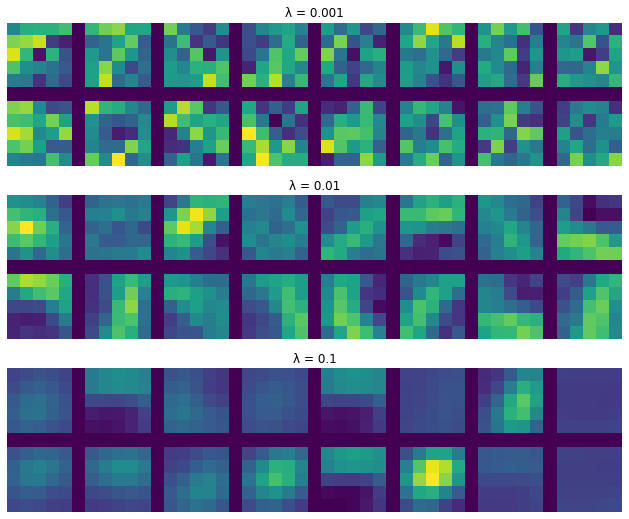

In [12]:
t2_s2_figure, t2_s2_axes = plt.subplots(3, 1, figsize=(12, 9))

for i, folder_path in enumerate(t2_s2_folder_paths[:3]):
    current_image_path = os.path.join(folder_path, sorted(os.listdir(folder_path))[-1])

    t2_s2_axes[i].imshow(plt.imread(current_image_path), interpolation="nearest")
    t2_s2_axes[i].set_title(f"λ = {t2_weight_decays[i]}")
    t2_s2_axes[i].axis("off")

Konsekventno, čitanjem datoteke `out_l2reg/results.json` možemo usporediti dobivene točnosti:

In [13]:
with open(t2_results_path) as file:
    t2_s2_results = json.load(file)

In [14]:
t2_s2_string = "<br>"

for i, weight_decay in enumerate(sorted(t2_weight_decays)):
    t2_s2_string += f"\n<br>Točnost za λ = {weight_decay}:&nbsp;&nbsp;&nbsp;" +\
                    f"".join(["&nbsp;&nbsp;" for _ in range(i)]) +\
                    f"<strong>{t2_s2_results[str(weight_decay)]:.02f}%</strong>"
    
HTML(t2_s2_string)

**Komentar**:

Na prvi pogled se čini kako je najmanji iznos regularizacije dao najbolju mrežu radi najveće točnosti. Ovo možda i jest istina. Međutim, ako pogledamo slike, možemo uočiti da su za $\lambda = 10^{-2}$ prvi konvolucijski slojevi daleko interpretabilniji od ostalih - vidimo linije, krivulje, horizontalne i dijagonalne praznine i sl. Dok u dubokom učenje interpretabilnost ne rezultira bolji rezultatima, tj. obično bude i suprotno, radi se u prvom sloju, koji izvlači značajke iz slike. Prema tome, vjerojatno ćemo, ako se radi o slikama koje su jednostavne kao MNIST, imati bolje rezultate ako su i filteri prvog sloja interpretabilni.

# Zadatak 3 &nbsp;&nbsp;&nbsp; (25%)

### Usporedba s PyTorchem

#### [<- Zadatak 2](#Zadatak-2-%C2%A0%C2%A0%C2%A0-(25%)) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [Zadatak 4 ->](#Zadatak-4-%C2%A0%C2%A0%C2%A0-(25%))

## Postavke zadatka

In [15]:
t3_do_train = False  # True ako želite pokrenuti trening u podzadatku 1, False inače.
                     # Upozorenje - to traje skoro 1 sat!

t3_root_path = "out_task3"
t3_results_filename = "results.json"
t3_weight_decays = [1e-3, 1e-2, 1e-1]

U PyTorchu definirajte i naučite model koji je ekvivalentan regulariziranom modelu iz [2. zadatka](#Zadatak-2). Koristite identičnu arhitekturu i parametre učenja da biste reproducirali rezultate. Konvoluciju zadajte operacijama [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) ili [`torch.nn.functional.conv2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d).

### Podzadatak 1

Tijekom učenja vizualizirajte filtre u prvom sloju kao u prethodnoj vježbi. Nakon svake epohe učenja pohranite filtre i gubitak u datoteku (ili koristite [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html)).

In [16]:
t3_s1_display = ""

if t3_do_train:
    t3_s1_mnist_dict = prepare_MNIST()

    for weight_decay in [1e-3, 1e-2, 1e-1]:
        model = CNNT3()
        model.float()

        model.tr(t3_s1_mnist_dict["x"][0], t3_s1_mnist_dict["y"][0],
                 t3_s1_mnist_dict["x"][1], t3_s1_mnist_dict["y"][1],
                 weight_decay=weight_decay)
else:
    t3_s1_display = "<br>Postavljeno je da se treniranje <strong>ne pokreće</strong> " +\
                    "(<code>t3_do_train == False</code>)."

HTML(t3_s1_display)

**Komentar**

Umjesto svakih $5000$ epoha, ovo ćemo raditi jednom po epohi. Ne vidim razlog zašto bi se to radilo češće jer je trening ovakve mreže volatilan samo na početku, pa bi češće spremanje slika bilo opravdano jedino u prvoj epohi.

### Podzadatak 2

Na kraju učenja prikažite kretanje gubitka kroz epohe (Matplotlib).

**Odgovor**:

Prvo ćemo učitati sve puteve do datoteka:

In [17]:
t3_s2_folder_paths = [os.path.join(t3_root_path, f"lambda{x:.03f}") for x in t3_weight_decays]

t3_s2_image_paths = list()
t3_s2_results_paths = list()

for folder_path in t3_s2_folder_paths:
    last_filter_path = sorted([x for x in os.listdir(folder_path) if x.endswith(".png")],
                               key=lambda x: x.lower())[-1]
    
    t3_s2_image_paths.append(os.path.join(folder_path, last_filter_path))
    t3_s2_results_paths.append(os.path.join(folder_path, t3_results_filename))

Zatim možemo prikazati posljednje filtre za različite parametre $\lambda$:

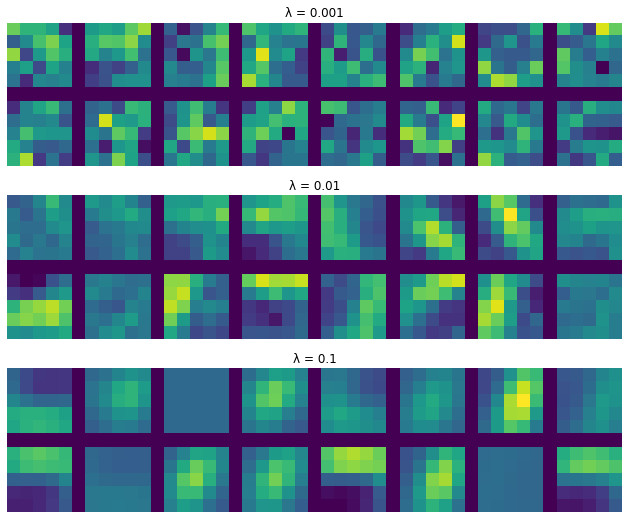

In [18]:
t3_s2_figure, t3_s2_axes = plt.subplots(3, 1, figsize=(12, 9))

for i, image_path in enumerate(t3_s2_image_paths):
    t3_s2_axes[i].imshow(plt.imread(image_path), interpolation="nearest")
    t3_s2_axes[i].set_title(f"λ = {t2_weight_decays[i]}")
    t3_s2_axes[i].axis("off")

Konačno, možemo prikazati ovisnost gubitaka o epohama za sve 3 instance učenja:

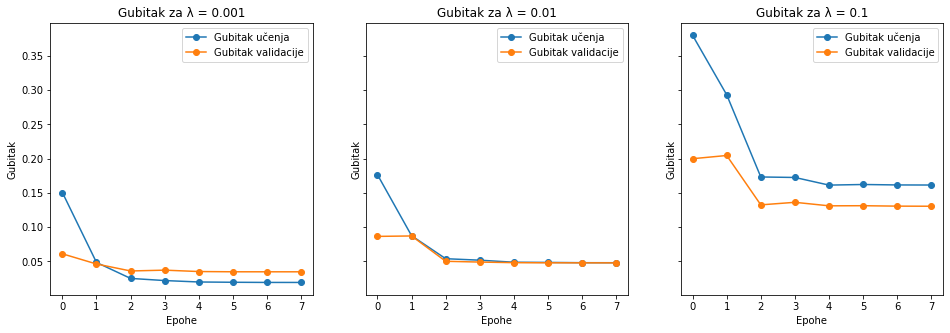

In [19]:
t3_s2_figure_l, t3_s2_axes_l = plt.subplots(1, 3, figsize=(16,5), sharey=True)

for i, result_path in enumerate(t3_s2_results_paths):
    with open(result_path) as file:
        loss_dict = json.load(file)
        
    loss, val_loss = [loss_dict[x] for x in ["loss", "val_loss"]]
    
    t3_s2_axes_l[i].set_title(f"Gubitak za λ = {t3_weight_decays[i]}")
    t3_s2_axes_l[i].set_xlabel(f"Epohe")
    t3_s2_axes_l[i].set_ylabel(f"Gubitak")
    
    t3_s2_axes_l[i].plot(range(len(loss)), loss, label="Gubitak učenja", marker="o")
    t3_s2_axes_l[i].plot(range(len(val_loss)), val_loss, label="Gubitak validacije", marker="o")
    
    t3_s2_axes_l[i].legend()

# Zadatak 4 &nbsp;&nbsp;&nbsp; (25%)

### Klasifikacija na skupu CIFAR-10

#### [<- Zadatak 3](#Zadatak-3-%C2%A0%C2%A0%C2%A0-(25%))

## Postavke zadatka

In [20]:
t4_do_train = False  # True ako želite pokrenuti trening u podzadatku 2, False inače.
                     # Upozorenje - to traje 30 minuta, ali sama validacija zauzima
                     # oko 33 GB RAMa - pripremite veliki SWAP!

t4_root_path = "out_task4"

t4_results_tr_file_path = os.path.join(t4_root_path, "results_tr.json")
t4_results_val_file_path = os.path.join(t4_root_path, "results_val.json")
t4_learning_rates_file_path = os.path.join(t4_root_path, "learning_rates.json")

t4_model_path = os.path.join(t4_root_path, "model.pt")

t4_s5_path = os.path.join(t4_root_path, "t4_s5")
t4_s5_best_classes_path = os.path.join(t4_s5_path, "best_classes.json")
t4_s5_worst_classes_path = os.path.join(t4_s5_path, "worst_classes.json")

Skup podataka [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) sastoji se od $50000$ slika za učenje i validaciju te $10000$ slika za testiranje dimenzija $32 \times 32$ podijeljenih u $10$ razreda.

### Podzadatak 1

Najprije skinite dataset pripremljen za Python [odavde](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) ili korištenjem [`torchvision.datasets.CIFAR10`](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar).

**Odgovor**:

Skup podataka je inicijalno preuzet s [sljedeće poveznice](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), raspakiran i smješten u `datasets/CIFAR`.

### Podzadatak 2

Vaš zadatak je da u PyTorchu naučite konvolucijski model na ovom skupu.

**Odgovor**:

Ovo ćemo učiniti s nešto drukčijom arhitekturom od predložene:

$
\begin{align}
    & \mathrm{Conv2D \space 64 @ 7 \times 7}  \\
    & \mathrm{MaxPool(2,2)}                   \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm2D}                    \\\\
%
    & \mathrm{Conv2D \space 64 @ 5 \times 5}  \\
    & \mathrm{MaxPool(2,2)}                   \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm2D}                    \\\\
%
    & \mathrm{Conv2D \space 64 @ 3 \times 3}  \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm2D}                    \\
    & \mathrm{Conv2D \space 128 @ 3 \times 3} \\
    & \mathrm{MaxPool(2,2)}                   \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm2D}                    \\\\
%
    & \mathrm{Flatten}                        \\\\
%
    & \mathrm{Dense(512)}                     \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm}                      \\\\
%
    & \mathrm{Dense(256)}                     \\
    & \mathrm{PReLU}                          \\
    & \mathrm{BatchNorm}                      \\\\
%
    & \mathrm{Dense(10)}                      \\
\end{align}
$

**Komentar**:

Razlog za ovoliko drukčiji model su bolje performanse, i u smislu brže konvergencije, i u smislu postizanja bolje točnost bez augmentacije.

In [21]:
t4_s2_cifar_dict = prepare_CIFAR()

In [22]:
t4_s2_display = ""

if t4_do_train:
    model = CNNT4()
    model.float()

    model.tr(t4_s2_cifar_dict["x"][0], t4_s2_cifar_dict["y"][0],
             t4_s2_cifar_dict["x"][1], t4_s2_cifar_dict["y"][1],
             n_epochs=16, batch_size=16, weight_decay=1e-4)

    torch.save(model, os.path.join(t4_root_path, "model.pt"))
else:
    t4_s2_display = "<br>Postavljeno je da se treniranje **ne pokreće**" +\
                    "(`t4_do_train == False`)."

Markdown(t4_s2_display)

<br>Postavljeno je da se treniranje **ne pokreće**(`t4_do_train == False`).

### Podzadatak 3

Napišite funkciju `evaluate` koja na temelju predviđenih i točnih indeksa razreda određuje pokazatelje klasifikacijske performanse: ukupnu točnost klasifikacije, matricu zabune (engl. confusion matrix) u kojoj retci odgovaraju točnim razredima a stupci predikcijama te mjere preciznosti i odziva pojedinih razreda. U implementaciji prvo izračunajte matricu zabune, a onda sve ostale pokazatelje na temelju nje. Tijekom učenja pozivajte funkciju `evaluate` nakon svake epohe na skupu za učenje i validacijskom skupu te na grafu pratite sljedeće vrijednosti: prosječnu vrijednost funkcije gubitka, stopu učenja te ukupnu točnost klasifikacije. Preporuka je da funkciji provedete samo unaprijedni prolaz kroz dane primjere koristeći `torch.no_grad()` i pritom izračunati matricu zabune. Pazite da slučajno ne pozovete i operaciju koja provodi učenje tijekom evaluacije. Na kraju funkcije možete izračunati ostale pokazatelje te ih isprintati.

**Odgovor**:

Implementacija je ostvarena unutar klase `CNNT4` koja je unutar modula `task_4.py`:

In [23]:
with open(t4_results_tr_file_path) as file:
    t4_s3_results_tr = json.load(file)
    
with open(t4_results_val_file_path) as file:
    t4_s3_results_val = json.load(file)
    
with open(t4_learning_rates_file_path) as file:
    t4_s3_learning_rates = json.load(file)

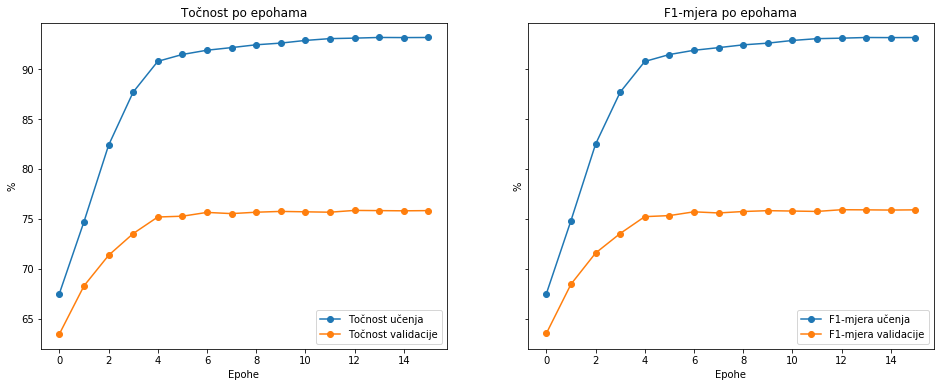

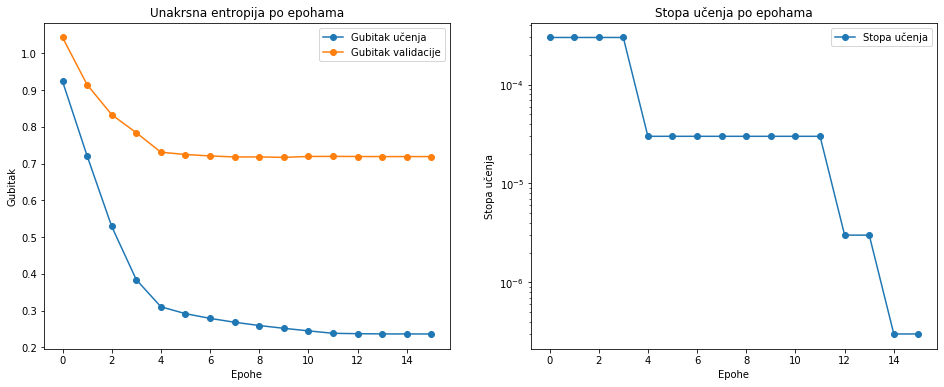

In [24]:
t4_s3_metric_fig, t4_s3_metric_ax = plt.subplots(1, 2, figsize=(16,6), sharey=True)
t4_s3_tr_metric_fig, t4_s3_tr_metric_ax = plt.subplots(1, 2, figsize=(16,6))

t4_s3_metric_ax[0].set_title("Točnost po epohama")
t4_s3_metric_ax[0].set_xlabel("Epohe")
t4_s3_metric_ax[0].set_ylabel("%")

t4_s3_metric_ax[0].plot(range(len(t4_s3_results_tr["acc"])),
                        [x * 100 for x in t4_s3_results_tr["acc"]],
                        label="Točnost učenja",
                        marker="o")
t4_s3_metric_ax[0].plot(range(len(t4_s3_results_val["acc"])),
                        [x * 100 for x in t4_s3_results_val["acc"]],
                        label="Točnost validacije",
                        marker="o")


t4_s3_metric_ax[1].set_title("F1-mjera po epohama")
t4_s3_metric_ax[1].set_xlabel("Epohe")
t4_s3_metric_ax[1].set_ylabel("%")

t4_s3_metric_ax[1].plot(range(len(t4_s3_results_tr["f1"])),
                        [x * 100 for x in t4_s3_results_tr["f1"]],
                        label="F1-mjera učenja",
                        marker="o")
t4_s3_metric_ax[1].plot(range(len(t4_s3_results_val["f1"])),
                        [x * 100 for x in t4_s3_results_val["f1"]],
                        label="F1-mjera validacije",
                        marker="o")


t4_s3_tr_metric_ax[0].set_title("Unakrsna entropija po epohama")
t4_s3_tr_metric_ax[0].set_xlabel("Epohe")
t4_s3_tr_metric_ax[0].set_ylabel("Gubitak")

t4_s3_tr_metric_ax[0].plot(range(len(t4_s3_results_tr["loss"])),
                           t4_s3_results_tr["loss"],
                           label="Gubitak učenja",
                           marker="o")
t4_s3_tr_metric_ax[0].plot(range(len(t4_s3_results_val["loss"])),
                           t4_s3_results_val["loss"],
                           label="Gubitak validacije",
                           marker="o")


t4_s3_tr_metric_ax[1].set_title("Stopa učenja po epohama")
t4_s3_tr_metric_ax[1].set_xlabel("Epohe")
t4_s3_tr_metric_ax[1].set_ylabel("Stopa učenja")
t4_s3_tr_metric_ax[1].set_yscale("log")

t4_s3_tr_metric_ax[1].plot(range(len(t4_s3_learning_rates)),
                           t4_s3_learning_rates,
                           label="Stopa učenja",
                           marker="o")

for i in range(2):
    t4_s3_metric_ax[i].legend()
    t4_s3_tr_metric_ax[i].legend()

**Komentar**:

Gornji red grafova dijeli y-os (jer se radi o metrikama koje su koliko-toliko srodne). Primijetite da donji desni graf ima logaritamsku y-os.

### Podzadatak 4

Vizualizirajte slučajno inicijalizirane težine konvolucijskog sloja.

**Odgovor**:

Prikazat ćemo prvi konvolucijski sloj na početku učenja (nasumično inicijaliziran) i na kraju učenja:

In [25]:
t4_s4_image_names = sorted([x for x in os.listdir(t4_root_path) if x.endswith(".png")],
                           key=lambda x: x.lower())
t4_first_last = t4_s4_image_names[0], t4_s4_image_names[-1]

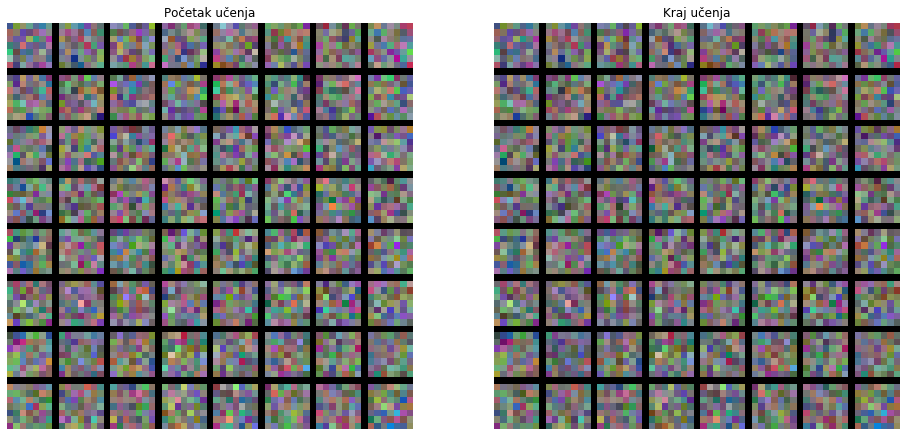

In [26]:
t4_s4_figure, t4_s4_axes = plt.subplots(1, 2, figsize=(16, 8))

for i, (image_name, title) in enumerate(zip(t4_first_last,
                                            ["Početak učenja", "Kraj učenja"])):
    t4_s4_axes[i].imshow(plt.imread(os.path.join(t4_root_path, image_name)), interpolation="nearest")
    t4_s4_axes[i].set_title(title)
    t4_s4_axes[i].axis("off")

**Komentar**:

Jako je teško vidjeti razliku ova dva sloja. Razlog za to je što smo koristili grupnu normalizaciju (engl. *batch normalization*), pa nam L2 regularizacija nije bila potrebna. No, zbog toga što grupna normalizacija ne sređuje težine, već ima svoje parametre koje utječu na podatke koji protječu kroz mrežu, taj utjecaj nije vidljiv u samim filtrima 1. konvolucijskog sloja, već bi se nad njim trebala napraviti transformacija koja bi onda bila ekvivalentna 1. filtru konvolucijskog sloja **bez** grupne normalizacije.

Izrada takve transformacije je izvan okvira ove vježbe.

### Podzadatak 5

Prikažite $20$ netočno klasificiranih slika s najvećim gubitkom te ispišite njihov točan razred, kao i $3$ razreda za koje je model dao najveću vjerojatnost.

**Odgovor**:

Ovo ćemo postići koristeći metodu `analyze_evaluation` u modulu `task_4.py`. Također, prije snimanja normalizirat ćemo slike po uputama. To možemo učiniti koristeći rječnik koji nam vraća metoda `prepare_CIFAR` jer će ona vratiti rječnik s unosima `mean` i `std` koji predstavljaju očekivanu vrijednost i standardnu devijaciju.

Prvo moramo učitati model i prebaciti ga u mod evaluacije:

In [27]:
t4_s5_model = torch.load(t4_model_path)
t4_s5_model.eval();

Zatim možemo pozvati `analyze_evaluation` nad njim i testnim skupom (testni skup je 3. član trojke koje vraća metoda `prepare_CIFAR` za `x` i `y`:

In [28]:
analyze_evaluation(model=t4_s5_model,
                   x=t4_s2_cifar_dict["x"][2],
                   y=t4_s2_cifar_dict["y"][2],
                   mean=t4_s2_cifar_dict["mean"],
                   std=t4_s2_cifar_dict["std"])

100%|██████████| 10000/10000 [00:00<00:00, 67816.98it/s]


Imena labela nalaze se u listi `cifar_labels`. Pomoću njih možemo prikazati $20$ najgorih slika:

In [29]:
with open(t4_s5_best_classes_path) as file:
    t4_s5_best_classes = json.load(file)
    
with open(t4_s5_worst_classes_path) as file:
    t4_s5_worst_classes = json.load(file)

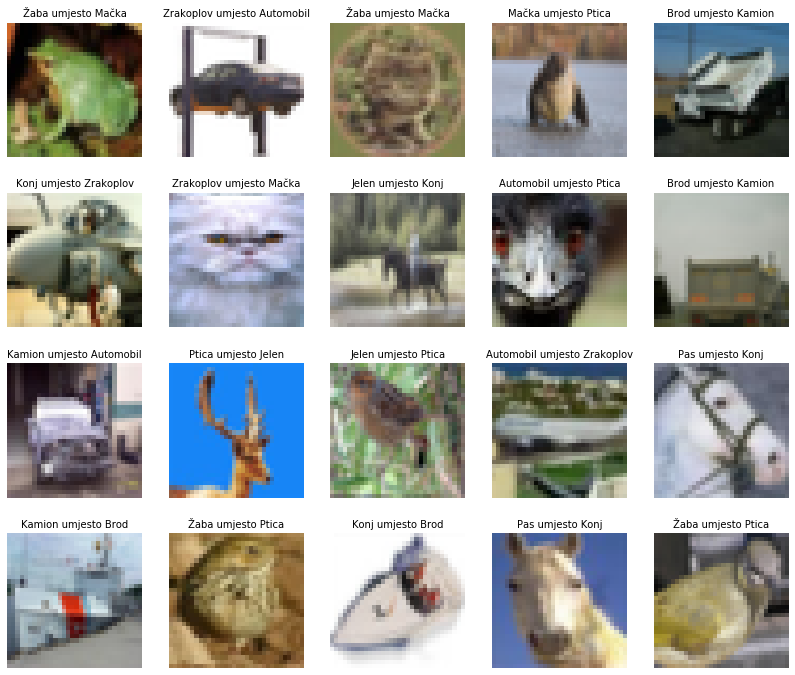

In [30]:
t4_s5_n_cols = 5
t4_s5_figure, t4_s5_axes = plt.subplots(20 // t4_s5_n_cols, t4_s5_n_cols, figsize=(14, 12))

for i, image_path in enumerate(sorted([x for x in os.listdir(t4_s5_path) if x.endswith(".png")])):
    a = i // t4_s5_n_cols
    b = i % t4_s5_n_cols

    t4_s5_axes[a][b].imshow(plt.imread(os.path.join(t4_s5_path, image_path)), interpolation="nearest")
    t4_s5_axes[a][b].set_title(f"{cifar_labels[t4_s5_worst_classes[i][1]]} " +\
                               f"umjesto {cifar_labels[t4_s5_worst_classes[i][0]]}")
    t4_s5_axes[a][b].axis("off")
    t4_s5_axes[a][b].title.set_fontsize(10)

**Komentar**:

Vidimo da je klasifikator najnesigurniji za neke nejednoznačne slike. Neke slike je teško opravdati kao pogreške:
- $7$ (Zrakoplov umjesto Mačka)
- $9$ (Automobil umjesto Ptica)
- $12$ (Ptica umjesto Jelen)
- $13$ (Jelen umjesto Ptica)
- $15$ (Pas umjesto Konj)

Kod ovih slika bi vjerojatno pomogao veći raspon rezolucija jer se radi o slikama koje objekt prikazuju iz blizine, dakle u detaljima koji se vjerojatno veći nega za ostatak slika.

Finalno, prikazat ćemo $3$ razreda za koje mreža najbolje rasuđuje:

In [31]:
t4_t5_display = f"<br>Mreža najtočnije rasuđuje sljedeće razrede:\n"

for class_id, prob in t4_s5_best_classes:
    t4_t5_display += f"- **{cifar_labels[class_id]}**: {prob * 100:.02f}%\n"
    
Markdown(t4_t5_display)

<br>Mreža najtočnije rasuđuje sljedeće razrede:
- **Automobil**: 85.80%
- **Brod**: 85.40%
- **Kamion**: 83.80%
